<a href="https://colab.research.google.com/github/Man2Dev/colab/blob/master/MainProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**import the dataset**

In [ ]:
#from google.colab import files
#uploaded = files.upload()

In [24]:
import requests
from IPython.display import display
import pandas as pd
import io
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
# dataset = pd.read_csv(io.BytesIO(uploaded['alcohol.csv']))


# Define the countries and indicators
countries = ["IRN", "DEU", "IND"]  # Iran, Germany, India
country_mapping = {
    "IRN": "Iran",
    "DEU": "Germany",
    "IND": "India"
}

# Initialize an empty DataFrame to store combined data
combined_df = pd.DataFrame()

# Fetch data separately for each country
for country in countries:
    for indicator in indicators:
        # Fetch data from the World Bank API
        url = f"https://api.worldbank.org/v2/country/{country}/indicator/{indicator}?date={start_year}:{end_year}&format=json"
        response = requests.get(url)
        if response.status_code == 200:
            data = response.json()
            if len(data) > 1:
                df = pd.json_normalize(data[1])  # Flatten the JSON data
                # Keep only necessary columns
                df = df[["countryiso3code", "indicator.value", "date", "value"]]
                df.columns = ["Country", "Series Name", "Year", "Value"]

                # Replace country codes with country names immediately
                df["Country"] = df["Country"].map(country_mapping).fillna(df["Country"])

                combined_df = pd.concat([combined_df, df], ignore_index=True)
            else:
                print(f"No data found for {country} ({indicator})")
        else:
            print(f"Error fetching data for {country} ({indicator}): {response.status_code}")

# Pivot the data to create year columns (e.g., 2000, 2001, etc.)
if not combined_df.empty:
    reshaped_df = combined_df.pivot_table(
        index=["Country", "Series Name"],  # Use Country and Series Name as the index
        columns="Year",                   # Use Year as columns
        values="Value",                   # Fill the table with the values
        aggfunc="first"                   # Handle duplicate entries
    ).reset_index()

    # Clean up column names to match the required format
    reshaped_df.columns = [
        str(int(col)) if isinstance(col, int) else col
        for col in reshaped_df.columns
    ]

    # Display the reshaped data
    print(reshaped_df)
else:
    print("No data was fetched from the API.")

    Country                                        Series Name     2000  \
0   Germany     Incidence of tuberculosis (per 100,000 people)   12.000   
1   Germany  Total alcohol consumption per capita (liters o...   13.820   
2   Germany  Total alcohol consumption per capita, female (...    6.210   
3   Germany  Total alcohol consumption per capita, male (li...   22.020   
4     India     Incidence of tuberculosis (per 100,000 people)  322.000   
5     India  Total alcohol consumption per capita (liters o...    1.970   
6     India  Total alcohol consumption per capita, female (...    0.600   
7     India  Total alcohol consumption per capita, male (li...    3.270   
8      Iran     Incidence of tuberculosis (per 100,000 people)   23.000   
9      Iran  Total alcohol consumption per capita (liters o...    0.021   
10     Iran  Total alcohol consumption per capita, female (...    0.005   
11     Iran  Total alcohol consumption per capita, male (li...    0.037   

       2001     2002    

**Comparing TB incidence in Iran , India and Germany from 2000 to 2020 per 100,000 people**

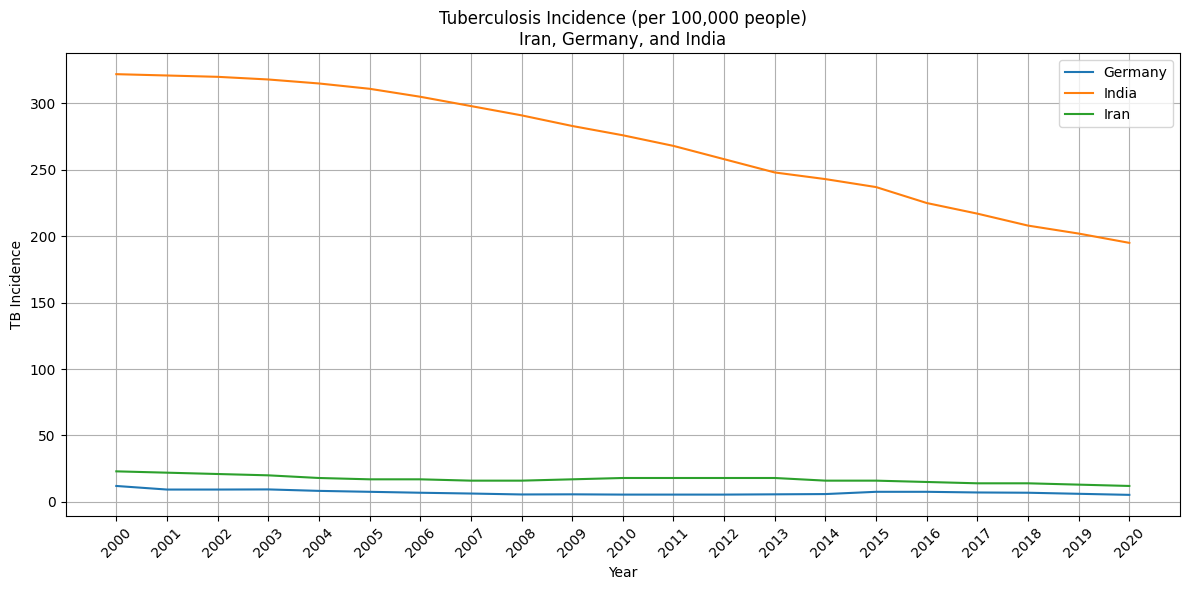

In [25]:
dataset = reshaped_df
tb_data = dataset[dataset['Series Name'] == 'Incidence of tuberculosis (per 100,000 people)'].copy()

# Extract year columns and convert values to numeric
year_columns = tb_data.columns[2:]
tb_data.loc[:, year_columns] = tb_data.loc[:, year_columns].apply(pd.to_numeric, errors='coerce')

# Now filter using the updated 'Country' column and full country names
countries_of_interest = ["Iran", "Germany", "India"]  # Full country names
tb_selected = tb_data[tb_data['Country'].isin(countries_of_interest)]


# Clean year labels for x-axis
years_cleaned = [col.split()[0] for col in year_columns]

# Plotting
plt.figure(figsize=(12, 6))
for _, row in tb_selected.iterrows():
    plt.plot(years_cleaned, row[year_columns], label=row['Country'])

plt.title('Tuberculosis Incidence (per 100,000 people)\nIran, Germany, and India')
plt.xlabel('Year')
plt.ylabel('TB Incidence')
plt.legend()  # Ensure there are proper labels
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

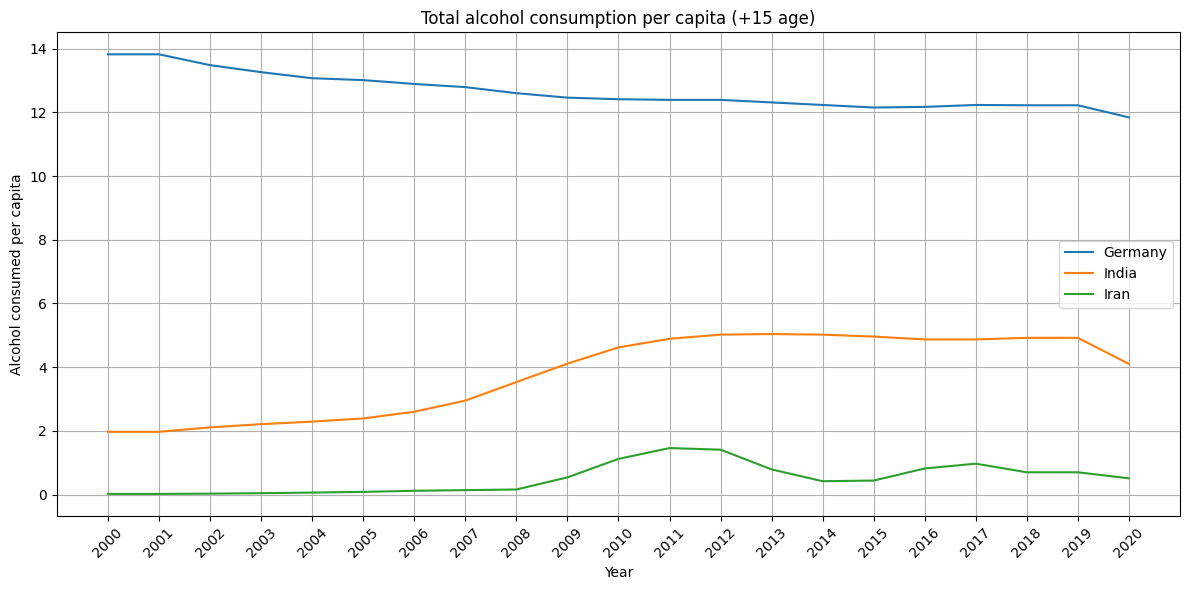

In [26]:
al_data = dataset[dataset['Series Name'] == 'Total alcohol consumption per capita (liters of pure alcohol, projected estimates, 15+ years of age)'].copy()

# Extract year columns and convert values to numeric
year_columns = al_data.columns[2:]
al_data[year_columns] = al_data[year_columns].apply(pd.to_numeric, errors='coerce')

# Now filter using the updated 'Country' column and full country names:
countries_of_interest = ["Iran", "Germany", "India"]
al_selected = al_data[al_data['Country'].isin(countries_of_interest)]

# Clean year labels for x-axis
years_cleaned = [col.split()[0] for col in year_columns]

# Plotting
plt.figure(figsize=(12, 6))
for _, row in al_selected.iterrows():
    plt.plot(years_cleaned, row[year_columns], label=row['Country'])

plt.title('Total alcohol consumption per capita (+15 age)')
plt.xlabel('Year')
plt.ylabel('Alcohol consumed per capita')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

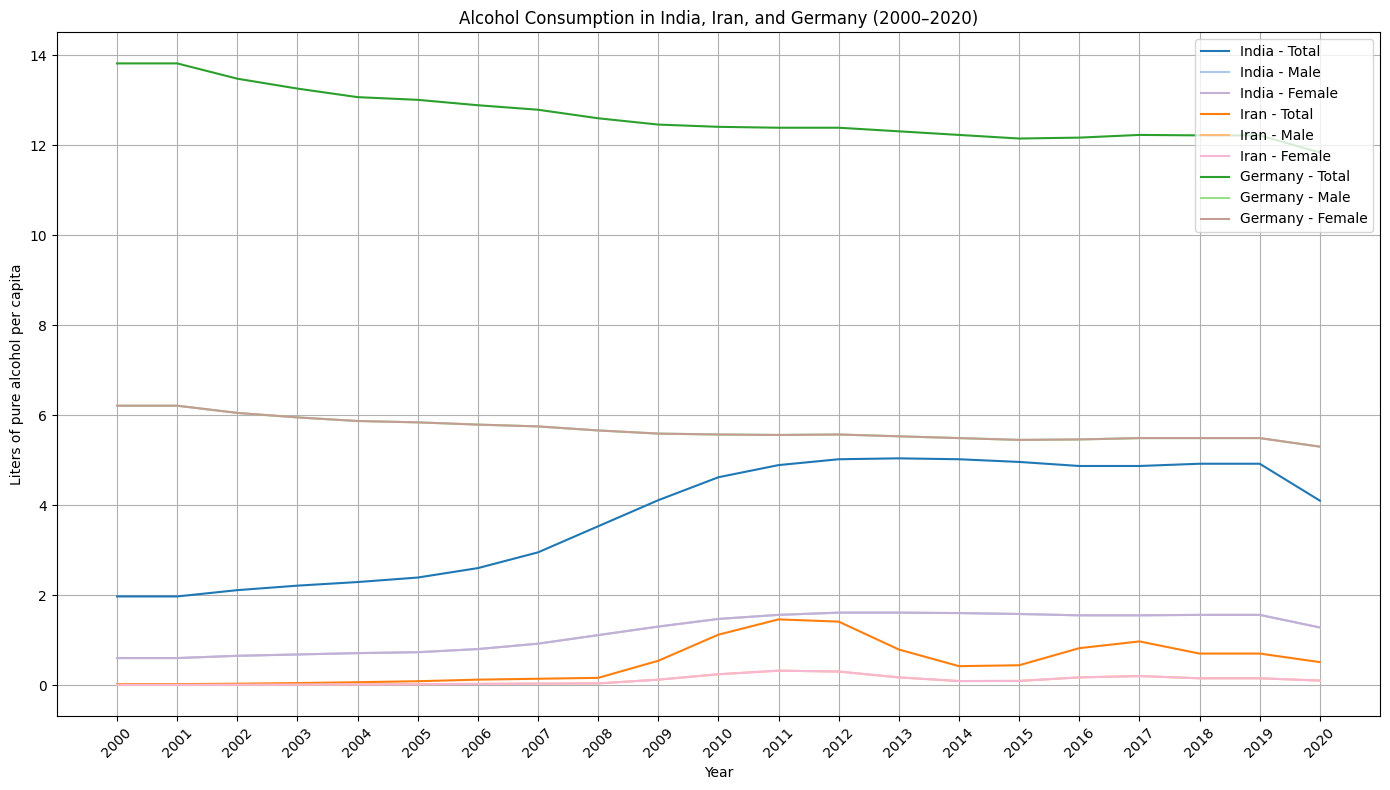

In [27]:
# Clean null Series Name
df = reshaped_df[reshaped_df["Series Name"].notna()]

# Countries of interest
countries = ["India", "Iran", "Germany"]
df = df[df["Country"].isin(countries)]

# Extract years (ensure year columns are correctly identified)
years = [col for col in df.columns if col.isdigit()]  # Numeric year columns

# Define unique colors for each (country, label)
line_colors = {
    ("India", "Total"): "#1f77b4",
    ("India", "Male"): "#aec7e8",
    ("India", "Female"): "#c5b0d5",

    ("Iran", "Total"): "#ff7f0e",
    ("Iran", "Male"): "#ffbb78",
    ("Iran", "Female"): "#f7b6d2",

    ("Germany", "Total"): "#2ca02c",
    ("Germany", "Male"): "#98df8a",
    ("Germany", "Female"): "#c49c94"
}

# Plotting
plt.figure(figsize=(14, 8))

for country in countries:
    for label in ["Total", "Male", "Female"]:
        # Use case-insensitive substring matching for Series Name
        match = df[
            (df["Country"] == country) &
            (df["Series Name"].str.contains("Total alcohol consumption per capita", case=False)) &
            (df["Series Name"].str.contains(label, case=False))
        ]
        # Check if data exists for this combination
        if not match.empty:
            plt.plot(
                years,
                match.iloc[0][years].values,  # Plot the year's data as numeric values
                label=f"{country} - {label}",
                color=line_colors[(country, label)]
            )
        else:
            print(f"No data found for {country} - {label}")

# Add legend and finalize the plot
plt.xticks(rotation=45)
plt.xlabel("Year")
plt.ylabel("Liters of pure alcohol per capita")
plt.title("Alcohol Consumption in India, Iran, and Germany (2000–2020)")
plt.legend()  # Ensure legend is added only for valid plots
plt.grid(True)
plt.tight_layout()
plt.show()

**Finding statistical values for Tuborculosis data for Iran**

In [28]:
tuberiran = dataset.iloc[0, 2:].values
# Ensure x is a NumPy array of floats
tuberiran = tuberiran.astype(float)
print(f"Tuberculosis Incidence per 100,000 people in Iran")
# Calculate statistics
mean_valtubeiran = np.mean(tuberiran)
median_valtubeiran = np.median(tuberiran)
mode_valtubeiran = stats.mode(tuberiran, keepdims=True)[0][0]
iqr_valtubeiran = stats.iqr(tuberiran)
min_valtubeiran = np.min(tuberiran)
max_valtubeiran = np.max(tuberiran)
std_devtubeiran = np.std(tuberiran)
variancetubeiran = np.var(tuberiran)

# Print results
print("Interquartile Range (IQR):", iqr_valtubeiran)
print("Minimum:", min_valtubeiran)
print("Maximum:", max_valtubeiran)
print("Standard Deviation:", std_devtubeiran)
print("Variance:", variancetubeiran)

Tuberculosis Incidence per 100,000 people in Iran
Interquartile Range (IQR): 1.8999999999999995
Minimum: 5.3
Maximum: 12.0
Standard Deviation: 1.7101935284528198
Variance: 2.9247619047619056


**Visualizing statistical values for Tuborculosis data for Iran**

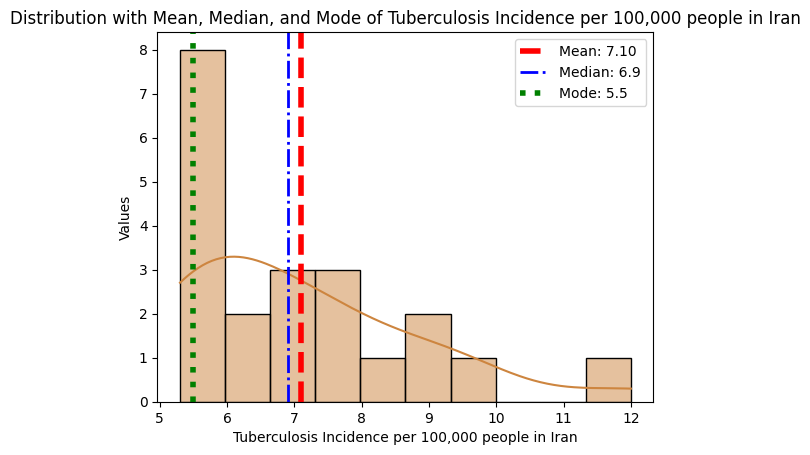

In [29]:
import seaborn as sns
sns.histplot(tuberiran, kde=True, color='peru', bins=10)
# Overlay mean, median, and mode
plt.axvline(mean_valtubeiran, color='red', linestyle='--', linewidth=4, label=f'Mean: {mean_valtubeiran:.2f}')
plt.axvline(median_valtubeiran, color='blue', linestyle='-.', linewidth=2, label=f'Median: {median_valtubeiran}')
plt.axvline(mode_valtubeiran, color='green', linestyle=':', linewidth=4, label=f'Mode: {mode_valtubeiran}')

# Add legend and labels
plt.legend()
plt.title('Distribution with Mean, Median, and Mode of Tuberculosis Incidence per 100,000 people in Iran')
plt.xlabel('Tuberculosis Incidence per 100,000 people in Iran')
plt.ylabel('Values')
plt.show()

 The orange line represents the median (50th percentile) 
 The box extends from 25th percentile to 75th percentile while the whiskers are the potential outliers


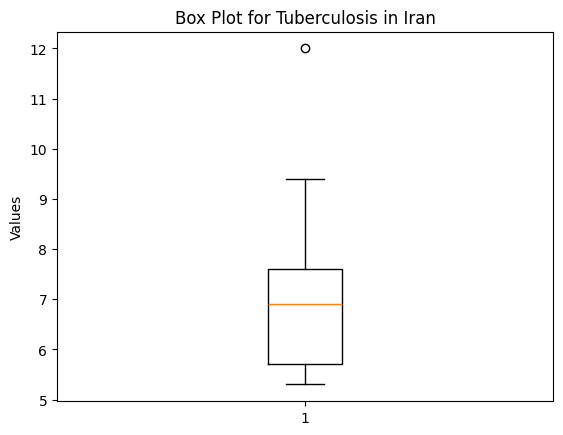

In [30]:
print(f"\033[1m The orange line represents the median (50th percentile) \033[0m")
print(f" The box extends from 25th percentile to 75th percentile while the whiskers are the potential outliers")
plt.boxplot(tuberiran)
plt.title("Box Plot for Tuberculosis in Iran")
plt.ylabel("Values")
plt.show()

**Finding statistical values for Tuborculosis data for India**

In [31]:
tuberindia = dataset.iloc[4, 2:].values
# Ensure x is a NumPy array of floats
tuberindia = tuberindia.astype(float)
print(f"Tuberculosis Incidence per 100,000 people in Iran")
# Calculate statistics
mean_valtubeindia = np.mean(tuberindia)
median_valtubeindia = np.median(tuberindia)
mode_valtubeindia = stats.mode(tuberindia, keepdims=True)[0][0]
iqr_valtubeindia = stats.iqr(tuberindia)
min_valtubeindia = np.min(tuberindia)
max_valtubeindia = np.max(tuberindia)
std_devtubeindia = np.std(tuberindia)
variancetubeindia = np.var(tuberindia)

# Print results
print("Interquartile Range (IQR):", iqr_valtubeindia)
print("Minimum:", min_valtubeindia)
print("Maximum:", max_valtubeindia)
print("Standard Deviation:", std_devtubeindia)
print("Variance:", variancetubeindia)

Tuberculosis Incidence per 100,000 people in Iran
Interquartile Range (IQR): 74.0
Minimum: 195.0
Maximum: 322.0
Standard Deviation: 42.45061155941935
Variance: 1802.0544217687075


**Visualizing statistical values for Tuborculosis data for India**

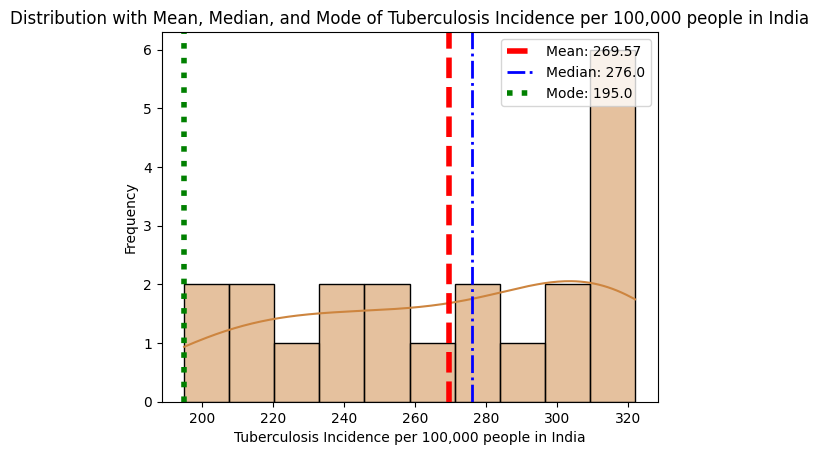

In [32]:
import seaborn as sns
sns.histplot(tuberindia, kde=True, color='peru', bins=10)
# Overlay mean, median, and mode
plt.axvline(mean_valtubeindia, color='red', linestyle='--', linewidth=4, label=f'Mean: {mean_valtubeindia:.2f}')
plt.axvline(median_valtubeindia, color='blue', linestyle='-.', linewidth=2, label=f'Median: {median_valtubeindia}')
plt.axvline(mode_valtubeindia, color='green', linestyle=':', linewidth=4, label=f'Mode: {mode_valtubeindia}')

# Add legend and labels
plt.legend()
plt.title('Distribution with Mean, Median, and Mode of Tuberculosis Incidence per 100,000 people in India')
plt.xlabel('Tuberculosis Incidence per 100,000 people in India')
plt.ylabel('Frequency')
plt.show()

 The orange line represents the median (50th percentile) 
 The box extends from 25th percentile to 75th percentile while the whiskers are the potential outliers


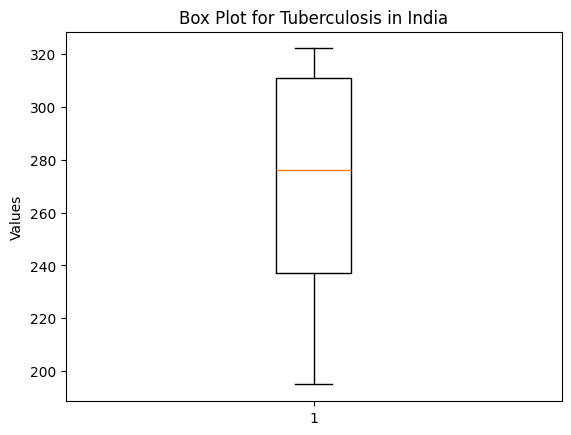

In [33]:
print(f"\033[1m The orange line represents the median (50th percentile) \033[0m")
print(f" The box extends from 25th percentile to 75th percentile while the whiskers are the potential outliers")
plt.boxplot(tuberindia)
plt.title("Box Plot for Tuberculosis in India")
plt.ylabel("Values")
plt.show()

**Finding statistical values for Tuborculosis data for Germany**

In [34]:
tuberGermany = dataset.iloc[8, 2:].values
# Ensure x is a NumPy array of floats
tuberGermany = tuberGermany.astype(float)
print(f"Tuberculosis Incidence per 100,000 people in Germany")
# Calculate statistics
mean_valtubeGermany = np.mean(tuberGermany)
median_valtubeGermany = np.median(tuberGermany)
mode_valtubeGermany = stats.mode(tuberGermany, keepdims=True)[0][0]
iqr_valtubeGermany = stats.iqr(tuberGermany)
min_valtubeGermany = np.min(tuberGermany)
max_valtubeGermany = np.max(tuberGermany)
std_devtubeGermany = np.std(tuberGermany)
variancetubeGermany = np.var(tuberGermany)

# Print results
print("Interquartile Range (IQR):", iqr_valtubeGermany)
print("Minimum:", min_valtubeGermany)
print("Maximum:", max_valtubeGermany)
print("Standard Deviation:", std_devtubeGermany)
print("Variance:", variancetubeGermany)

Tuberculosis Incidence per 100,000 people in Germany
Interquartile Range (IQR): 2.0
Minimum: 12.0
Maximum: 23.0
Standard Deviation: 2.741302469452239
Variance: 7.514739229024944


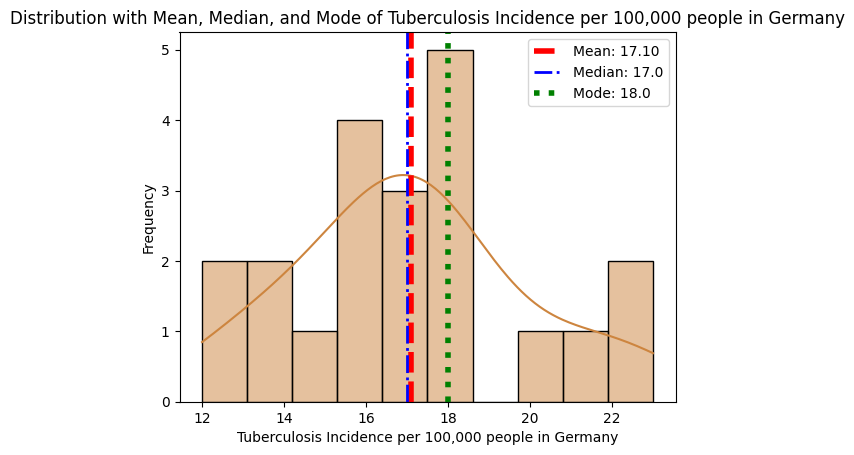

In [35]:
sns.histplot(tuberGermany, kde=True, color='peru', bins=10)
# Overlay mean, median, and mode
plt.axvline(mean_valtubeGermany, color='red', linestyle='--', linewidth=4, label=f'Mean: {mean_valtubeGermany:.2f}')
plt.axvline(median_valtubeGermany, color='blue', linestyle='-.', linewidth=2, label=f'Median: {median_valtubeGermany}')
plt.axvline(mode_valtubeGermany, color='green', linestyle=':', linewidth=4, label=f'Mode: {mode_valtubeGermany}')

# Add legend and labels
plt.legend()
plt.title('Distribution with Mean, Median, and Mode of Tuberculosis Incidence per 100,000 people in Germany')
plt.xlabel('Tuberculosis Incidence per 100,000 people in Germany')
plt.ylabel('Frequency')
plt.show()

 The orange line represents the median (50th percentile) 
 The box extends from 25th percentile to 75th percentile while the whiskers are the potential outliers


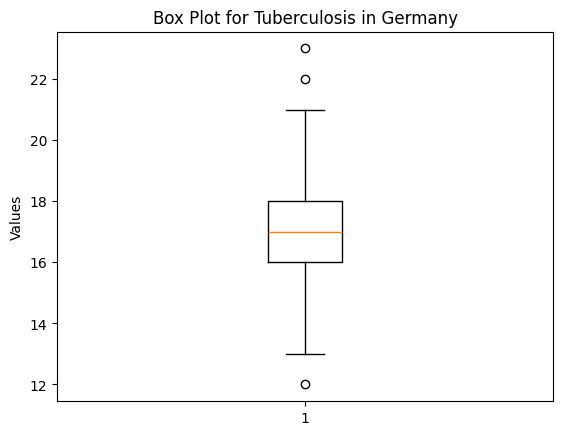

In [36]:
print(f"\033[1m The orange line represents the median (50th percentile) \033[0m")
print(f" The box extends from 25th percentile to 75th percentile while the whiskers are the potential outliers")
plt.boxplot(tuberGermany)
plt.title("Box Plot for Tuberculosis in Germany")
plt.ylabel("Values")
plt.show()